In [1]:
import pandas as pd
import plotly.express as px
from d3blocks import D3Blocks
import matplotlib.pyplot as plt
from time import strftime
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("data/input/historical_air_quality_2021_en.csv")

# Pre-processing data for descriptive analysis

## Summarization data
---

In [3]:
description = df.describe()
mode = df.select_dtypes(include=['float64','int64']).mode().iloc[0]
mode.name = 'mode'
median = df.select_dtypes(include=['float64','int64']).median()
median.name = 'median'
description = description._append(mode)._append(median)
print(description)

          Station ID          Dew     Humidity  Temperature         Wind
count    2622.000000  2263.000000  2608.000000  2615.000000  2615.000000
mean    11079.826087    22.248210    75.790529    26.227036     2.922141
std      3548.080424     4.256875    16.469530     4.733196     3.886933
min      1584.000000     5.500000    13.000000     0.500000     0.200000
25%      8767.000000    20.750000    62.400000    23.000000     2.000000
50%     13012.000000    22.900000    78.000000    26.000000     2.800000
75%     13019.000000    25.000000    88.500000    29.500000     3.600000
max     13252.000000    29.000000   100.000000    39.000000   150.000000
mode     1584.000000    22.000000    78.000000    26.000000     3.000000
median  13012.000000    22.900000    78.000000    26.000000     2.800000


### Check the rate of missing data

In [4]:
data_na = (df.isnull().sum() / len(df)) * 100
missing_data = pd.DataFrame({"Tỷ lệ thiếu data(%)" : data_na})
print(missing_data)

                    Tỷ lệ thiếu data(%)
Station ID                     0.000000
AQI index                      0.152555
Location                       0.000000
Station name                   0.000000
Url                            0.000000
Dominent pollutant            19.374523
CO                             0.266972
Dew                           13.691838
Humidity                       0.533944
NO2                            0.266972
O3                             0.533944
Pressure                       0.533944
PM10                           1.487414
PM2.5                          0.305111
SO2                            0.305111
Temperature                    0.266972
Wind                           0.266972
Data Time S                    0.000000
Data Time Tz                   0.000000
Status                         0.000000
Alert level                    0.000000


### Check the rate of duplicate data

In [5]:
duplicated_rows_data = df.duplicated().sum()
print(f"\nSố lượng data trùng lặp: {duplicated_rows_data}")


Số lượng data trùng lặp: 497


### Count distinct data for each column

In [6]:
print("\nSố lượng data riêng biệt:")
num_distinct_values = []
for column in df.columns:
    num_distinct_values.append(len(df[column].unique()))
distinct_values_df = pd.DataFrame({'Column': df.columns, 'NumDistinctValues': num_distinct_values})
print(distinct_values_df)


Số lượng data riêng biệt:
                Column  NumDistinctValues
0           Station ID                 23
1            AQI index                208
2             Location                 23
3         Station name                 23
4                  Url                 23
5   Dominent pollutant                  4
6                   CO                 66
7                  Dew                157
8             Humidity                317
9                  NO2                 87
10                  O3                 87
11            Pressure                318
12                PM10                167
13               PM2.5                211
14                 SO2                 99
15         Temperature                182
16                Wind                 51
17         Data Time S                431
18        Data Time Tz                  1
19              Status                  5
20         Alert level                  5


### Preview 5 first rows of dataset

In [7]:
print(f"\n5 First Rows:\n {df.head(5)}")


5 First Rows:
    Station ID AQI index                Location   
0        8767       102    10.782978,106.700711  \
1        8688       221  21.0811211,105.8180306   
2        8641       281  21.0215063,105.8188748   
3       13012        36    13.998599,107.996482   
4       12488        68     16.46226,107.596351   

                                        Station name   
0  Ho Chi Minh City US Consulate, Vietnam (Lãnh s...  \
1  United Nations International School of Hanoi, ...   
2  Hanoi US Embassy, Vietnam (Đại sứ quán Mỹ, Hà ...   
3        Gia Lai/phường Thống Nhất - Pleiku, Vietnam   
4              Thừa Thiên Huế/83 Hùng Vương, Vietnam   

                                                 Url Dominent pollutant   CO   
0  https://aqicn.org/city/vietnam/ho-chi-minh-cit...               pm25    -  \
1          https://aqicn.org/city/vietnam/hanoi/unis                aqi    -   
2    https://aqicn.org/city/vietnam/hanoi/us-embassy               pm25  0.3   
3  https://aqicn.org

## Cleaning data
---

### Processing duplicate data

In [8]:
df.drop_duplicates(inplace=True)

### Processing inconsistent and typographical errors data

In [9]:
df_column_dtype = ['AQI index', 'CO', 'NO2', 'O3', 'SO2', 'Dew', 'Humidity', 'Pressure', 'PM10', 'PM2.5', 'Temperature', 'Wind']
result = []
for column in df_column_dtype:
    if df[column].dtype == 'object':
        unique_non_numeric_chars = df[column].str.extract('([^0-9])').drop_duplicates()
    else:
        unique_non_numeric_chars = df[column].astype(str).str.extract('([^0-9])').drop_duplicates()
    temp = unique_non_numeric_chars[0].tolist()
    for i in temp:
        if i not in result:
            result.append(i)
print(f"Những kí tự đặc biệt trong các cột có kiểu dữ liệu số: {result}")
print("=====================Replacing them by 0=====================")
df_column_dtype = ['AQI index', 'CO', 'NO2', 'O3', 'SO2', 'Dew', 'Humidity', 'Pressure', 'PM10', 'PM2.5', 'Temperature', 'Wind']
for i in df_column_dtype:
    df[i] = df[i].replace(result, 0)
    df[i] = df[i].fillna(0)
print("=============================================================")

Những kí tự đặc biệt trong các cột có kiểu dữ liệu số: [nan, '-', '.', 'n', ',']
=====================Replacing them by 0=====================


### Remove commas(",") in numbers

In [10]:
for column in df_column_dtype:
    if df[column].dtype == 'object':
        df[column] = df[column].str.replace(',', '', regex=True).astype(float)

### Process datetime

In [11]:
df['Data Time S'] = pd.to_datetime(df['Data Time S'])
df['Date'] = df['Data Time S'].dt.date

### Processing missing data for each numberic column (Fill by average monthly data)

In [12]:
for column in df_column_dtype:
    df[column] = df[column].astype(float)
    df = df.fillna(0)
df['Month'] = pd.to_datetime(df['Date']).dt.month
mean_value = df.groupby('Month')[df_column_dtype].mean()
for i in range(1, 12):
    for j in df_column_dtype:
        df[j] = df[j].where(df['Month'] == i, df[j].replace(0, mean_value[j].values[i - 1]))

### Processing missing data for each string column

In [13]:
def dominant_pollutant(row):
    if row['PM10'] > row['PM2.5']:
        return 'pm10'
    elif row['PM10'] < row['PM2.5']:
        return 'pm25'
    else:
        return 'pm10 + pm2.5'
df['Dominent pollutant'] = df.apply(dominant_pollutant, axis=1)
df.drop(['Date'], axis=1, inplace=True)


def myfunc(x):
    if x <= 50:
        return 1, "Good"
    elif x <= 100:
        return 2, "Moderate"
    elif x <= 150:
        return 3, "Unhealthy for Sensitive Group"
    elif x <= 200:
        return 4, "Unhealthy"
    elif x <= 300:
        return 5, "Very Unhealthy"
    else:
        return 6, "Hazardous"
df['Alert level'], df['Status'] = zip(*df['AQI index'].apply(myfunc))

## Normalization data
---

In [14]:
df = df[df['SO2']<df['SO2'].quantile(0.9)]

In [15]:
df.to_csv('data/result/pre-process-data.csv', index=False, encoding="utf-8")

# Descriptive Analysis
---

In [16]:
df = pd.read_csv("data/result/pre-process-data.csv")

### Line plot for pollution index by month

In [115]:
df_plt1 = df[df_column_dtype + ['Month']].groupby(['Month']).mean().reset_index()
fig = None
fig = px.line(title=f'Line Plot for pollution indexes')
for i in df_column_dtype:
    fig.add_scatter(x=df_plt1['Month'], y=df_plt1[i], mode='lines', name=f'{i}')
    fig.update_yaxes(title='Pollution index')
fig.show()

### Bar chart for pollution index by station id

In [119]:
df_plt2 = df[df_column_dtype + ['Station ID']].groupby('Station ID').mean().reset_index()
df_plt2['Station ID'] = df_plt2['Station ID'].astype('string')
for i in df_column_dtype:
    fig = px.bar(df_plt2, x='Station ID', y=f'{i}',
                title=f'{i}')
    fig.update_xaxes(title='Station ID')
    fig.update_yaxes(title=f'{i} mean')
    fig.show()

### Line plot for pollution index by month and station ID

In [23]:
df[['Latitude', 'Longtitude']] = df['Location'].str.split(",", expand=True)

In [42]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longtitude'] = df['Longtitude'].astype(float)

In [ ]:
import folium
map_center = [df['Latitude'].mean(), df['Longtitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=6)

for index, row in df.iterrows():
    lat, lon = map(float, row['Location'].split(','))
    folium.Marker([lat, lon], popup=f"Location: {row['Location']}").add_to(mymap)

folium.Choropleth(
    geo_data='map.geojson',
    data=df,
    columns=['Station ID', 'AQI index'],
    key_on='feature.properties.region',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Pollution Level',
).add_to(mymap)

# Display the map
mymap

### Moving Bubbles plot

In [122]:
df_plt4 = df[['Station ID', 'Data Time S', 'Status']]
df_plt4.rename(columns={"Station ID": "sample_id", "Data Time S": "datetime", "Status": "state"}, inplace=True)
df_plt4['datetime'] = pd.to_datetime(df_plt4['datetime'])
df_plt4['datetime'] = df_plt4['datetime'].dt.strftime("%d-%m-%Y %H:%M:%S")
d3 = D3Blocks()
d3.movingbubbles(df_plt4, datetime="datetime", sample_id="sample_id", state="state", filepath="./moving_point.html",
                 note="Vietnam's AQI index in 2021 for each day", cmap="hsv", center="Good", figsize=(780, 800), size=10, speed=1000000000)

C:\Users\Phuong\AppData\Local\Temp\ipykernel_12888\1180063710.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Phuong\AppData\Local\Temp\ipykernel_12888\1180063710.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Phuong\AppData\Local\Temp\ipykernel_12888\1180063710.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

100%|██████████| 23/23 [00:00<00:00, 515.47it/s]
[d3blocks] >INFO> Set all nodes to size: 10
[d3blocks] >WARNING> Colormap [Set1] can not create [23] unique colors! Available unique colors: [9].
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [c:\Users\Phuong\Desktop\ky5\ptdll\BTL\moving_point.html]
[d3blocks] >INFO> Open browser: c:\Users\Phuong\Desktop\ky5\ptdll\BTL\moving_point.html


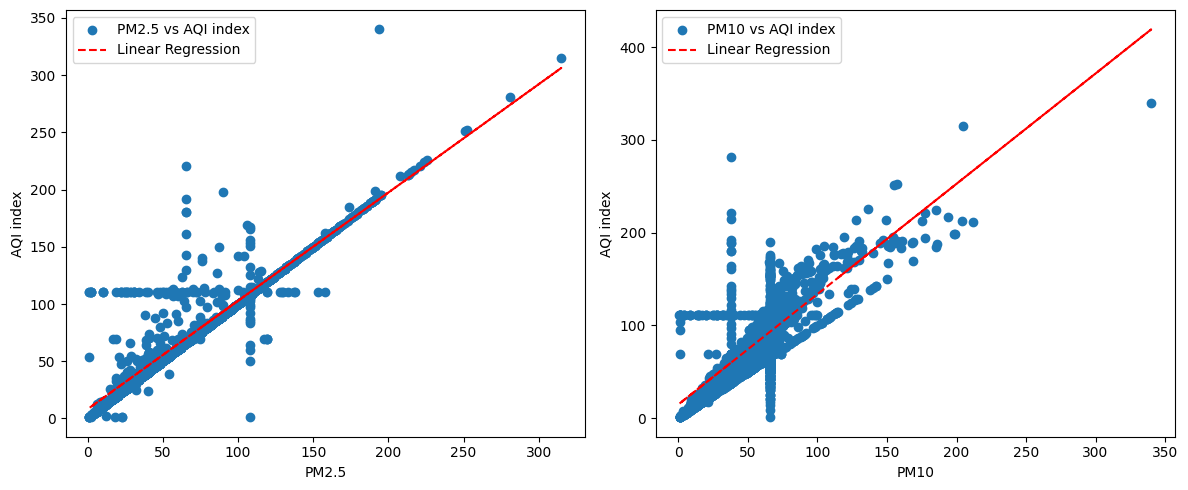

In [171]:
X = df[['PM2.5', 'PM10']]
Y = df['AQI index']

# Compare the dependence of variables
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, column in enumerate(X.columns):
    axes[i].scatter(X[column], Y, label=f'{column} vs AQI index')

    model = LinearRegression()
    model.fit(X[[column]], Y)
    axes[i].plot(X[column], model.predict(X[[column]]), color='red', linestyle='--', label='Linear Regression')

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('AQI index')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [190]:
# Multivariable regression model
model = LinearRegression()
model.fit(X, Y)
r2 = model.score(X, Y)
for i, column in enumerate(X.columns):
    print("Coefficient", f'{column}: {model.coef_[i]}')
print("Intercept:", model.intercept_)
print("R2-square: ", r2)

Coefficient PM2.5: 0.8482435763292312
Coefficient PM10: 0.18351937709259322
Intercept: 5.5677552739210086
R2-square:  0.8764028750500289


<p>=> y = 0.85*x1 + 0.18*x2 + 5.57</p>
y: AQI index predicted<br>
x1: PM2.5 index<br>
x2: PM10 index

In [188]:
pm25_new = float(input("Enter PM2.5: "))
pm10_new = float(input("Enter PM10 : "))
predicted_aqi = model.predict([[pm25_new, pm10_new]])[0]
print("PM2.5 =", pm25_new, "; PM10 =", pm10_new, "\n=> AQI index =", round(predicted_aqi, 2))

PM2.5 = 100.0 ; PM10 = 200.0 
=> AQI index = 127.1


c:\Users\Phuong\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
